## In this notebook, we are cleaning the 311 data from 2020-01-01 to 2021-03-31, so that we can better analyze the complaint type and evictions correlations.
## The analysis part is in a different notebook. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# data source:

file_path = '/content/drive/My Drive/X999/covid_data.csv'

In [4]:
# cleaning functions

# some cleaning ideas are from:
# https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis

def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

# drop columns that are empty or almost empty
def drop_empty_columns(df):
    # drop columns that are completely or almost empty
    # and get the count of NaNs in each column
    na_col_count = df.isna().sum()
    columns_to_drop = []
    # use .items() instead of .iteritems()
    for column, na_count in na_col_count.items():
      # Check if the column has 85% or more NaNs
        if na_count / len(df) >= 0.85:
            columns_to_drop.append(column)

    df.drop(columns_to_drop, axis=1, inplace=True)  # Drop the columns
    return df

# def drop_unneccessary_columns(df):
#     #drop the unneccesary columns
#     cols = ['x_coordinate_(state_plane)',"agency_name", "agency",
#        'y_coordinate_(state_plane)', 'open_data_channel_type',
#        'park_facility_name', 'park_borough', 'vehicle_type', 'due_date',
#        'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
#        'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment','resolution_action_updated_date']
#     df.drop(cols,axis=1,inplace=True)
#     return df

def drop_unneccessary_columns(df):
    columns_to_drop = ['x_coordinate_(state_plane)', 'agency_name', 'agency',
                       'y_coordinate_(state_plane)', 'open_data_channel_type',
                       'park_facility_name', 'park_borough', 'vehicle_type',
                       'due_date', 'taxi_company_borough', 'taxi_pick_up_location',
                       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
                       'bridge_highway_segment', 'facility_type', "community_board", "landmark"]

    # Drop the columns from the dataframe, only if they exist
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    return df_cleaned


In [33]:
complaints_df_raw = pd.read_csv(file_path)

In [40]:
# complaints_df_raw["Complaint Type"].unique()

In [41]:
complaints_df = complaints_df_raw.copy()

In [42]:
complaints_df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [43]:
# make sure the column names are all lower case with hiphen, so that it would easier for cleaning
complaints_df = clean_column_names(complaints_df)

In [44]:
# find complaint types that have something to do with noice or constructions
noise_construction_complaints = complaints_df[complaints_df['complaint_type'].str.contains(r'(?i)noise|construction', regex=True)]
noise_construction_complaints.complaint_type.unique()


array(['Noise - Residential', 'Noise - Helicopter', 'Noise - Commercial',
       'Noise - Street/Sidewalk', 'Noise', 'Noise - Vehicle',
       'General Construction/Plumbing', 'Noise - Park',
       'Collection Truck Noise', 'Construction Lead Dust',
       'Noise - House of Worship', 'COVID-19 Non-essential Construction',
       'Construction Safety Enforcement'], dtype=object)

In [51]:
# the type of complaints we want to keep: noise related
# AND we also want to keep the location type that is family residential related.
# so this is an OR situation, we keep them both here and do deeper cleaning later.

# following the last cell
noise_complaint_types = [
    'Noise - Residential', 'Noise - Helicopter', 'Noise - House of Worship', 'Noise - Commercial', 'Noise - Park',
    'Noise - Street/Sidewalk', 'Noise', 'Noise - Vehicle',
    'General Construction/Plumbing',
    'Collection Truck Noise', 'Construction Lead Dust',
    'COVID-19 Non-essential Construction',
    'Construction Safety Enforcement'
]

# particularly picked complaint types that tend to have stronger correlations between complaints and evictions.
must_include = [
    "Noise - Residential", "Unsanitary Condition", "Heat/Hot Water", "Flooring/Stairs", "Indoor Air Quality", "Smoking", "Door/Window",
    "Paint/Plaster", "Water Leak", "Electric", "Safety", "Plumbing", "Appliance", "Rodent", "Unsanitary Pigeon Condition", "Asbestos",
    "Elevator", "Construction Lead Dust", "Indoor Sewage", "Peeling Paint", "Window Guard", "Harboring Bees/Wasps", "Drinking Water",
    "Noise - Street/Sidewalk", "Mold"]

# filter rows where complaint_type is in the noise_complaint_types list or location_type contains the keywords
filtered_df = complaints_df[
    (complaints_df['complaint_type'].isin(noise_complaint_types)) |
     (complaints_df["complaint_type"].isin(must_include)) |
    (complaints_df['location_type'].str.contains(r'family|residential', case=False, na=False))
]

In [53]:
# basic cleaning
filtered_df = drop_unneccessary_columns(filtered_df)
filtered_df = drop_empty_columns(filtered_df)

In [54]:
filtered_df.complaint_type.unique(), len(filtered_df.complaint_type.unique())

(array(['Noise - Residential', 'Noise - Helicopter', 'Noise - Commercial',
        'HEAT/HOT WATER', 'Rodent', 'Noise - Street/Sidewalk',
        'Illegal Fireworks', 'PLUMBING', 'DOOR/WINDOW', 'Noise',
        'Noise - Vehicle', 'Elevator', 'WATER LEAK',
        'UNSANITARY CONDITION', 'General Construction/Plumbing',
        'Homeless Encampment', 'Animal-Abuse', 'PAINT/PLASTER',
        'APPLIANCE', 'FLOORING/STAIRS', 'Food Establishment', 'GENERAL',
        'Noise - Park', 'Graffiti', 'ELECTRIC', 'SAFETY',
        'Non-Emergency Police Matter', 'Unleashed Dog', 'ELEVATOR',
        'Smoking', 'Unsanitary Animal Pvt Property', 'Asbestos',
        'Plumbing', 'Indoor Sewage', 'Food Poisoning',
        'Collection Truck Noise', 'Panhandling', 'Indoor Air Quality',
        'OUTSIDE BUILDING', 'Unsanitary Pigeon Condition',
        'Non-Residential Heat', 'Construction Lead Dust',
        'Unsanitary Animal Facility', 'Mold', 'Noise - House of Worship',
        'Mobile Food Vendor', 'Day

In [55]:
filtered_df.location_type.unique()

array(['Residential Building/House', nan, 'Above Address',
       'Club/Bar/Restaurant', 'RESIDENTIAL BUILDING',
       '3+ Family Apt. Building', 'Street/Sidewalk', 'Store/Commercial',
       'Commercial Building', 'Residential Building',
       '1-2 Family Dwelling', 'Park/Playground', 'Residential',
       '1-2 Family Mixed Use Building', 'Street Area',
       'Other (Explain Below)', 'Day Care/Nursery', 'Apartment',
       '3+ Family Apartment Building', 'Residence', 'Construction Site',
       '3+ Family Mixed Use Building', 'Sidewalk', 'Other',
       'Building (Non-Residential)', 'Vacant Lot', 'House of Worship',
       'School', 'Restaurant/Bar/Deli/Bakery', 'Vacant Building',
       'Restaurant', 'Parking Lot/Garage', 'Cafeteria - Public School',
       'Abandoned Building', 'Public Garden', 'School - K-12 Private',
       'Store', '1-3 Family Dwelling', 'Private House', 'Retail Store',
       'School/Pre-School', 'Catch Basin/Sewer', 'Grocery Store',
       'Single Room Occup

In [ ]:
# # using regex to filter out relevant rows
# keywords = r'family|residential'
# complaints_df = complaints_df[complaints_df['location_type'].str.contains(keywords, case=False, na=False)]
# complaints_df.shape


In [16]:
# # change to datetime so that we do not have to do it later
# filtered_df.created_date =  pd.to_datetime(filtered_df.created_date)

In [17]:
# filtered_df.shape, \
# filtered_df.info()

In [56]:
filtered_df.shape, \
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1672828 entries, 10 to 3608800
Data columns (total 23 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   unique_key                      1672828 non-null  int64  
 1   created_date                    1672828 non-null  object 
 2   closed_date                     1661081 non-null  object 
 3   complaint_type                  1672828 non-null  object 
 4   descriptor                      1655155 non-null  object 
 5   location_type                   1502235 non-null  object 
 6   incident_zip                    1671525 non-null  float64
 7   incident_address                1666963 non-null  object 
 8   street_name                     1666943 non-null  object 
 9   cross_street_1                  1017936 non-null  object 
 10  cross_street_2                  1017908 non-null  object 
 11  intersection_street_1           972121 non-null   object 
 12  inte

((1672828, 23), None)

In [57]:
filtered_df.head(2)

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,address_type,city,status,resolution_description,resolution_action_updated_date,bbl,borough,latitude,longitude,location
10,45281175,01/01/2020 12:01:37 AM,01/01/2020 01:54:21 AM,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,2625 GRAND CONCOURSE,GRAND CONCOURSE,EAST 192 STREET,...,NaN,BRONX,Closed,The Police Department responded to the complai...,01/01/2020 01:54:23 AM,2.031680e+09,BRONX,40.865154,-73.895088,"(40.865154176445884, -73.89508805180566)"
11,45278238,01/01/2020 12:01:46 AM,01/01/2020 05:37:46 AM,Noise - Residential,Banging/Pounding,NaN,10025.0,865 COLUMBUS AVENUE,COLUMBUS AVENUE,WEST 100 STREET,...,NaN,NEW YORK,Closed,The Police Department responded to the complai...,01/01/2020 05:37:48 AM,1.018360e+09,MANHATTAN,40.796930,-73.964551,"(40.79692992181987, -73.96455113216999)"


In [58]:
filtered_df.complaint_type.unique(), len(filtered_df.complaint_type.unique())

(array(['Noise - Residential', 'Noise - Helicopter', 'Noise - Commercial',
        'HEAT/HOT WATER', 'Rodent', 'Noise - Street/Sidewalk',
        'Illegal Fireworks', 'PLUMBING', 'DOOR/WINDOW', 'Noise',
        'Noise - Vehicle', 'Elevator', 'WATER LEAK',
        'UNSANITARY CONDITION', 'General Construction/Plumbing',
        'Homeless Encampment', 'Animal-Abuse', 'PAINT/PLASTER',
        'APPLIANCE', 'FLOORING/STAIRS', 'Food Establishment', 'GENERAL',
        'Noise - Park', 'Graffiti', 'ELECTRIC', 'SAFETY',
        'Non-Emergency Police Matter', 'Unleashed Dog', 'ELEVATOR',
        'Smoking', 'Unsanitary Animal Pvt Property', 'Asbestos',
        'Plumbing', 'Indoor Sewage', 'Food Poisoning',
        'Collection Truck Noise', 'Panhandling', 'Indoor Air Quality',
        'OUTSIDE BUILDING', 'Unsanitary Pigeon Condition',
        'Non-Residential Heat', 'Construction Lead Dust',
        'Unsanitary Animal Facility', 'Mold', 'Noise - House of Worship',
        'Mobile Food Vendor', 'Day

In [60]:
# particularly filter out the complaint type that is Covid-19 Non essential Construction
filtered_df_covid = filtered_df[filtered_df['complaint_type'] == 'COVID-19 Non-essential Construction']
filtered_df_covid.shape, \
filtered_df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7119 entries, 540991 to 3606620
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      7119 non-null   int64  
 1   created_date                    7119 non-null   object 
 2   closed_date                     7119 non-null   object 
 3   complaint_type                  7119 non-null   object 
 4   descriptor                      7119 non-null   object 
 5   location_type                   0 non-null      object 
 6   incident_zip                    7111 non-null   float64
 7   incident_address                7119 non-null   object 
 8   street_name                     7119 non-null   object 
 9   cross_street_1                  0 non-null      object 
 10  cross_street_2                  0 non-null      object 
 11  intersection_street_1           0 non-null      object 
 12  intersection_street_2          

((7119, 23), None)

In [ ]:
# complaints_df = clean_column_names(complaints_df)

In [ ]:
# complaints_df = drop_unneccessary_columns(complaints_df)

In [ ]:
# complaints_df.shape, \
# complaints_df.info()

In [61]:
filtered_df.isna().sum().where(lambda x:x>0).dropna()

,0
closed_date,11747.0
descriptor,17673.0
location_type,170593.0
incident_zip,1303.0
incident_address,5865.0
street_name,5885.0
cross_street_1,654892.0
cross_street_2,654920.0
intersection_street_1,700707.0
intersection_street_2,700657.0


In [ ]:
# top_50_complaints = complaints_df['complaint_type'].value_counts().nlargest(50).index
# complaints_df_top50 = complaints_df[complaints_df['complaint_type'].isin(top_50_complaints)]


In [ ]:
# complaints_df_top50.shape

In [ ]:
# # drop rows that have NaN in geo data columns
# complaints_df_top50 = complaints_df_top50.dropna(subset=['latitude', 'longitude'])

In [64]:
filtered_df = filtered_df.dropna(subset=['bbl'])
filtered_df.shape

(1584853, 23)

In [63]:
filtered_df_covid = filtered_df_covid.dropna(subset=['bbl'])
filtered_df_covid.shape

(7029, 23)

In [65]:
# convert to datetime
filtered_df.created_date =  pd.to_datetime(filtered_df.created_date)
filtered_df.closed_date =  pd.to_datetime(filtered_df.closed_date)


In [66]:
filtered_df_covid.created_date = pd.to_datetime(filtered_df_covid.created_date)
filtered_df_covid.closed_date = pd.to_datetime(filtered_df_covid.closed_date)

In [67]:
filtered_df.created_date.min(), filtered_df.created_date.max(), \
filtered_df.closed_date.min(), filtered_df.closed_date.max()


(Timestamp('2020-01-01 00:01:37'),
 Timestamp('2021-03-30 23:58:10'),
 Timestamp('2019-07-18 00:00:00'),
 Timestamp('2024-09-16 00:00:00'))

In [68]:
filtered_df_covid.created_date.min(), filtered_df_covid.created_date.max(), \
filtered_df_covid.closed_date.min(), filtered_df_covid.closed_date.max()

(Timestamp('2020-03-30 15:17:55'),
 Timestamp('2021-03-30 17:50:16'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2023-08-08 00:00:00'))

In [69]:
# since we particularly have an interest in "Non-Essentail Covid Consturction noise" that was only
# present during covid, we particularly set the timeframe as 2020-03-15 to 2021-03-31
filtered_df = filtered_df[filtered_df['created_date'] > pd.Timestamp('2020-03-15 00:00:00')]
filtered_df_covid = filtered_df_covid[filtered_df_covid['created_date'] > pd.Timestamp('2020-03-15 00:00:00')]

In [71]:
filtered_df.loc[filtered_df.status.isin(['open','assigned','draft']),'status'] = 'closed'
filtered_df_covid.loc[filtered_df_covid.status.isin(['open','assigned','draft']),'status'] = 'closed'

In [72]:
# cleaning idea: https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis
city = filtered_df.city.mode()[0]
zipcode = filtered_df.loc[filtered_df.city == city,'incident_zip'].mode()[0]
latitude = filtered_df.loc[filtered_df['incident_zip'] == zipcode,'latitude'].mode()[0]
longitude = filtered_df.loc[filtered_df['incident_zip'] == zipcode,'longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
filtered_df.loc[filtered_df.city.isna(),'incident_zip'] = zipcode
filtered_df.loc[filtered_df.city.isna(),'city'] = city
filtered_df.loc[(filtered_df.city == city) & (filtered_df.latitude.isna()==True),'latitude'] = latitude
filtered_df.loc[(filtered_df.city == city) & (filtered_df.longitude.isna()==True),'longitude'] = longitude

In [74]:
city = filtered_df_covid.city.mode()[0]
zipcode = filtered_df_covid.loc[filtered_df_covid.city == city,'incident_zip'].mode()[0]
latitude = filtered_df_covid.loc[filtered_df_covid['incident_zip'] == zipcode,'latitude'].mode()[0]
longitude = filtered_df_covid.loc[filtered_df_covid['incident_zip'] == zipcode,'longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
filtered_df_covid.loc[filtered_df_covid.city.isna(),'incident_zip'] = zipcode
filtered_df_covid.loc[filtered_df_covid.city.isna(),'city'] = city
filtered_df_covid.loc[(filtered_df_covid.city == city) & (filtered_df_covid.latitude.isna()==True),'latitude'] = latitude
filtered_df_covid.loc[(filtered_df_covid.city == city) & (filtered_df_covid.longitude.isna()==True),'longitude'] = longitude

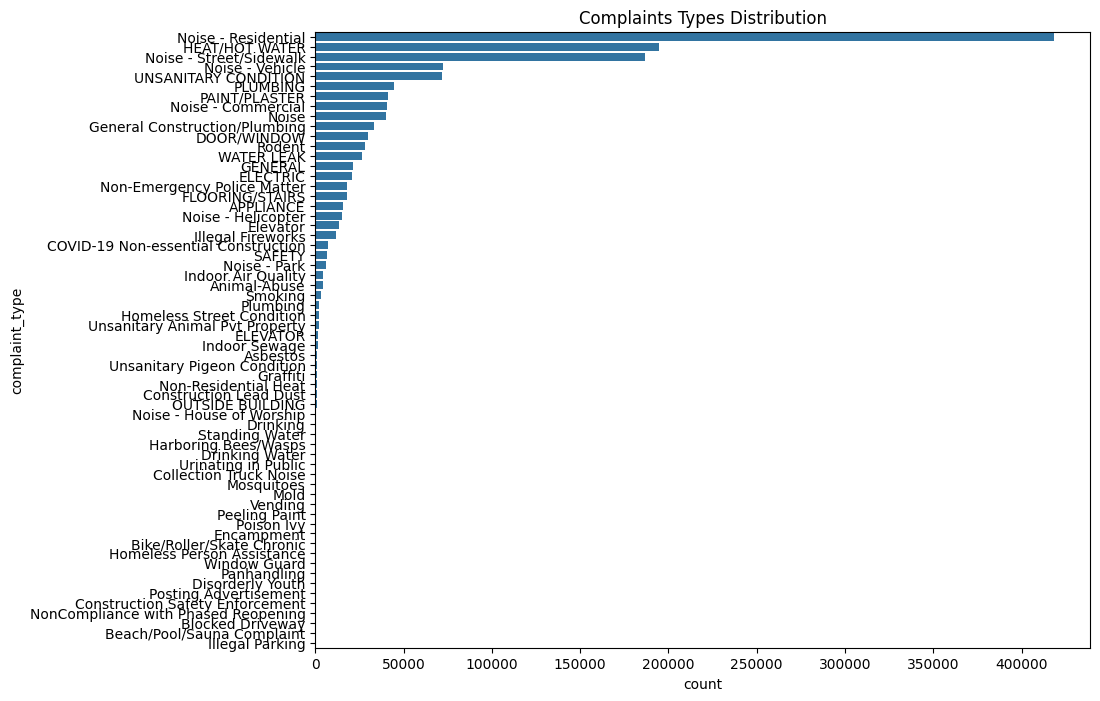

In [75]:
complaint_order = filtered_df['complaint_type'].value_counts().index
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=filtered_df, order=complaint_order)
plt.show()

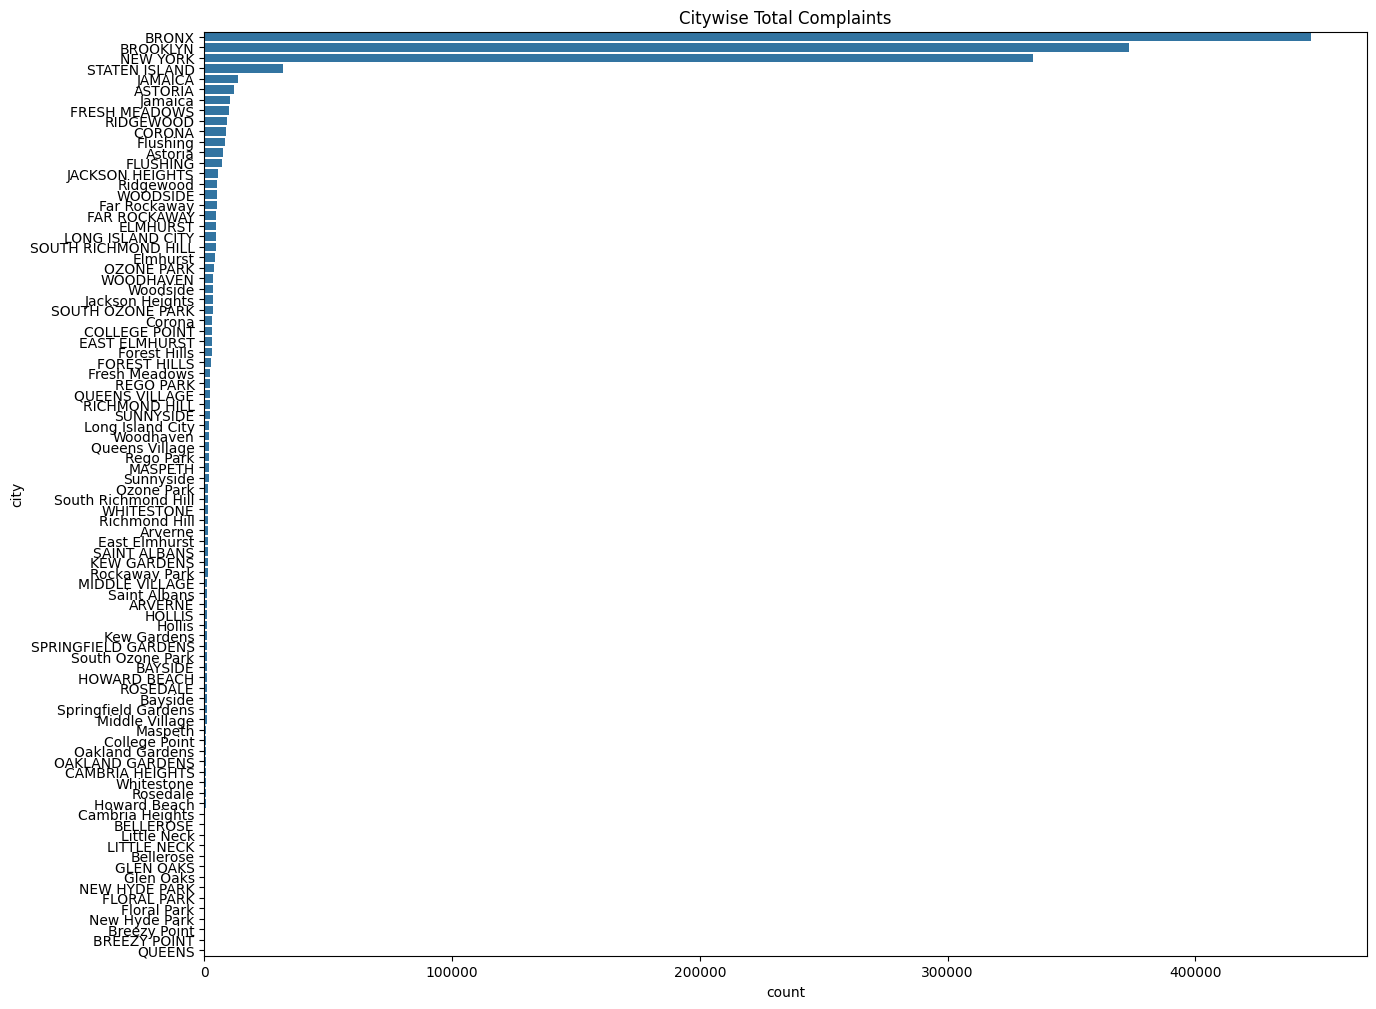

In [77]:
city_order = filtered_df['city'].value_counts().index
plt.figure(figsize=(15,12))
plt.title('Citywise Total Complaints')
sns.countplot(y='city', data=filtered_df, order=city_order)
plt.show()

In [83]:
# filtered_df.plot(kind='barh', stacked=True, figsize=(12,10))
# plt.title('Categorywise Complaints per City')
# plt.legend(loc='upper right')
# plt.show()

In [80]:
# save cleaned 2020-03-15 to 2021-03-31 complaints data to my drive
filtered_df.to_csv('/content/drive/My Drive/X999/filtered_df_covid_period_all.csv', index=False)

In [81]:
# save cleaned 2020-03-15 to 2021-03-31 only "non essential covid construction noise" complaints data to my drive
filtered_df_covid.to_csv('/content/drive/My Drive/X999/filtered_df_covid.csv', index=False)